In [7]:
#importing libraries

import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
import copy as cp

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters

In [2]:
dataDir='D:/MEU/Universidade/Codigo Tese/Dados/'
SegmentedData=pd.read_csv(dataDir+'SegmentedData.csv') #Ver Jupyter Notebook: "Segmenting Weighings" para
#encontrar o código que gerou o ficheiro 'SegmentedData.csv'
SegmentedData.drop(columns=['Unnamed: 0'],inplace=True)
SegmentedData['timestamp']= pd.to_datetime(SegmentedData['timestamp'])
SegmentedData['period']= pd.to_timedelta(SegmentedData['period'])
SegmentedData['diff']= pd.to_timedelta(SegmentedData['diff'])

In [3]:
#Creating a dataframe
d_df={'timestamp':[],'weight':[]}

In [4]:
for weighing in SegmentedData['weighing'][SegmentedData['weighing'].notnull()].unique():
    d_df['timestamp'].append(SegmentedData['timestamp'][SegmentedData['weighing']==weighing].iloc[0])
    d_df['weight'].append(SegmentedData['maximumWeight'][SegmentedData['weighing']==weighing].iloc[0])
weighingTimeSeries=pd.DataFrame(data=d_df)

In [9]:
weighingTimeSeries

,timestamp,weight
0,2019-05-10 11:15:54,30700.0
1,2019-05-10 11:21:18,22950.0
2,2019-05-10 11:59:39,12560.0
3,2019-05-10 12:02:54,25510.0
4,2019-05-10 12:47:30,10810.0
...,...,...
2893,2021-03-25 17:29:05,4200.0
2894,2021-03-26 07:28:13,22640.0
2895,2021-03-26 08:06:24,36460.0
2896,2021-03-26 08:46:26,14780.0


C:\Users\Leonardo\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Todas as Pesagens')

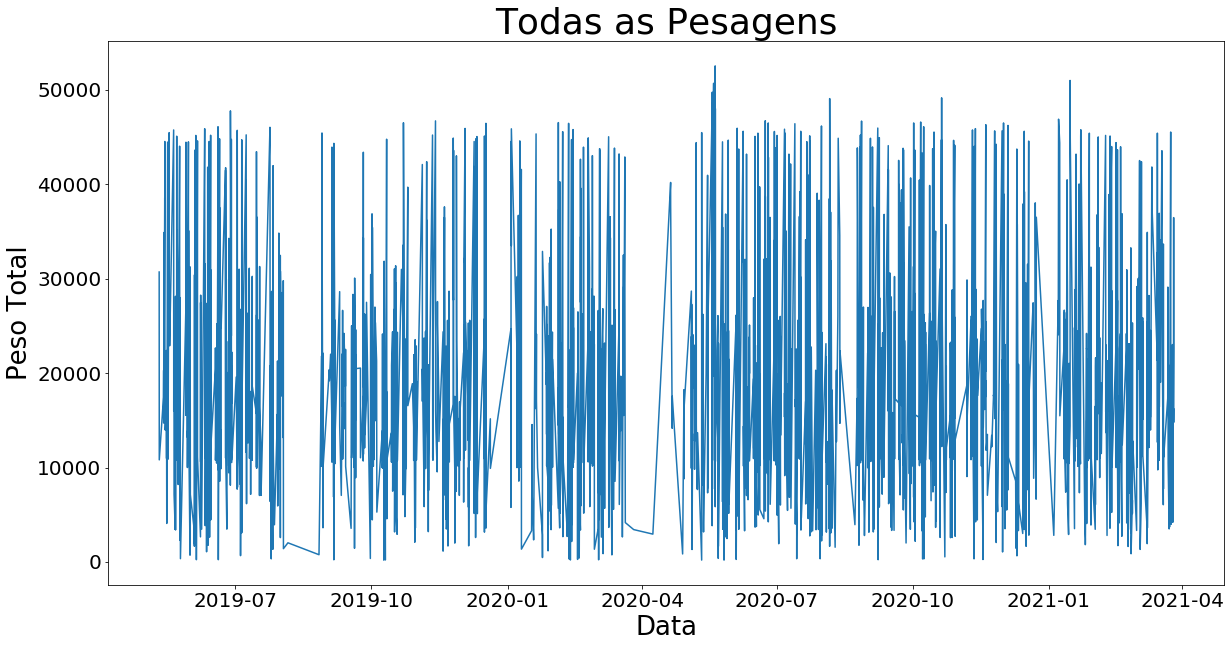

In [5]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 20})
plt.plot(weighingTimeSeries.timestamp, weighingTimeSeries.weight)#, 'g')
#plt.legend(['0','1','2','3','4','5','6','7'])
plt.xlabel('Data', fontsize=26)
plt.ylabel('Peso Total', fontsize=26)
plt.title('Todas as Pesagens', fontsize=36)

Text(0.5, 1.0, 'Todas as Medições')

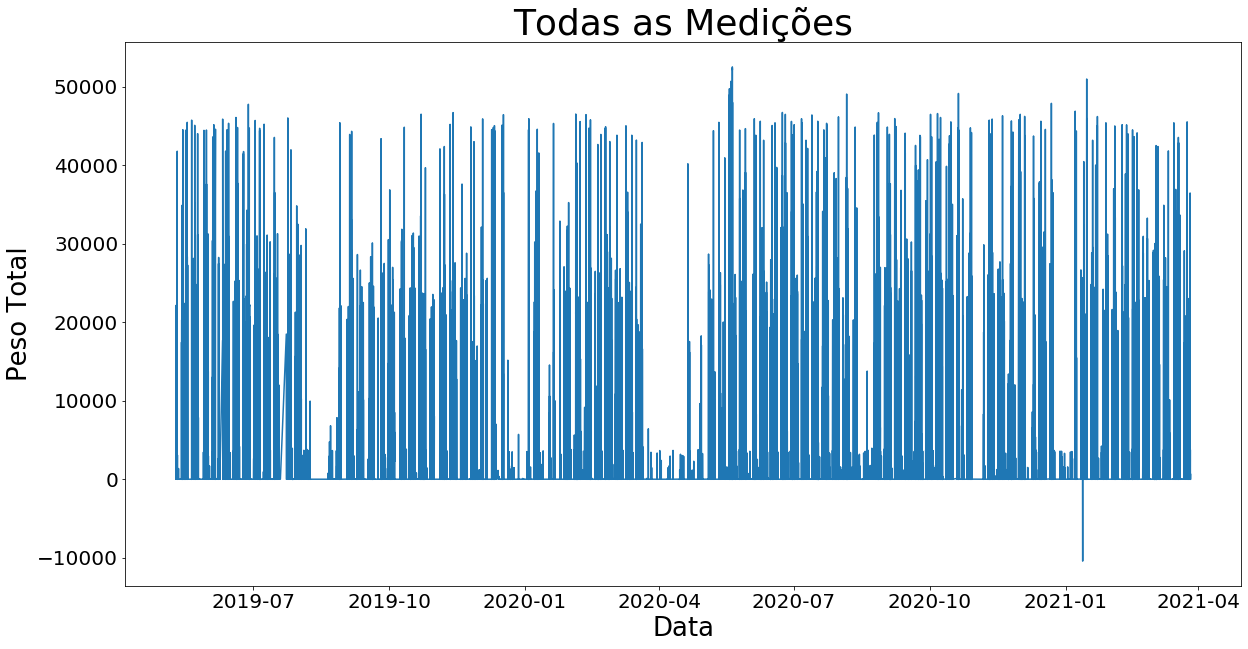

In [6]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 20})
plt.plot(SegmentedData.timestamp, SegmentedData.scaleGross)#, 'g')
#plt.legend(['0','1','2','3','4','5','6','7'])
plt.xlabel('Data', fontsize=26)
plt.ylabel('Peso Total', fontsize=26)
plt.title('Todas as Medições', fontsize=36)

In [10]:
weighingByDay = (pd.to_datetime(weighingTimeSeries['timestamp'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('date')
       .reset_index(name='count'))
weighingByDay=weighingByDay.sort_values(by=['date'])
weighingByDay.reset_index(drop=True,inplace=True)
weighingByDay

,date,count
0,2019-05-10,5
1,2019-05-13,7
2,2019-05-14,7
3,2019-05-15,7
4,2019-05-16,11
...,...,...
394,2021-03-22,4
395,2021-03-23,8
396,2021-03-24,8
397,2021-03-25,4


In [12]:
weighingByMonth=weighingByDay[['date','count']].groupby(weighingByDay.date.dt.to_period("M")).agg('count')
weighingByMonth=weighingByMonth.drop(columns=['date']).rename_axis('date').reset_index()
weighingByMonth['date'] = weighingByMonth['date'].astype(str)
weighingByMonth['date'] = pd.to_datetime(weighingByMonth['date'])
weighingByMonth

,date,count
0,2019-05-01,15
1,2019-06-01,20
2,2019-07-01,21
3,2019-08-01,6
4,2019-09-01,19
5,2019-10-01,22
6,2019-11-01,19
7,2019-12-01,10
8,2020-01-01,15
9,2020-02-01,19


In [13]:
weighingByWeek = weighingByDay.groupby(pd.Grouper(freq='W', key='date'))['count'].sum()
weighingByWeek =weighingByWeek.reset_index()
weighingByWeek

,date,count
0,2019-05-12,5
1,2019-05-19,37
2,2019-05-26,45
3,2019-06-02,25
4,2019-06-09,41
...,...,...
94,2021-02-28,41
95,2021-03-07,42
96,2021-03-14,28
97,2021-03-21,38


In [11]:
register_matplotlib_converters()

## Checking if the Series are stationary

In [14]:
def stationary(df):
    result = adfuller(df)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    return None

In [18]:
lista=[weighingByDay, weighingByWeek, weighingByMonth]
t=0
for item in lista:
    t=t+1
    print("\n \n periodo= ", t, '\n')
    stationary(item['count'])


 
 periodo=  1 

ADF Statistic: -12.71697684212979
p-value: 1.0015993797880997e-23
Critical Values:
	1%: -3.4469295619737665
	5%: -2.8688478565083417
	10%: -2.570662885558566

 
 periodo=  2 

ADF Statistic: -5.749011766774607
p-value: 6.027184399348249e-07
Critical Values:
	1%: -3.4989097606014496
	5%: -2.891516256916761
	10%: -2.5827604414827157

 
 periodo=  3 

ADF Statistic: -0.17231222867185322
p-value: 0.9417424575938154
Critical Values:
	1%: -3.9644434814814815
	5%: -3.0849081481481484
	10%: -2.6818144444444445


## A série mensal NÃO é ESTACIONÁRIA!!! (as restantes são com um intervalo de confiança superior a 99%)

## Tornando a Série Mensal Estacionária

In [27]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [28]:
weighingByMonth

,date,count
0,2019-05-01,15
1,2019-06-01,20
2,2019-07-01,21
3,2019-08-01,6
4,2019-09-01,19
5,2019-10-01,22
6,2019-11-01,19
7,2019-12-01,10
8,2020-01-01,15
9,2020-02-01,19


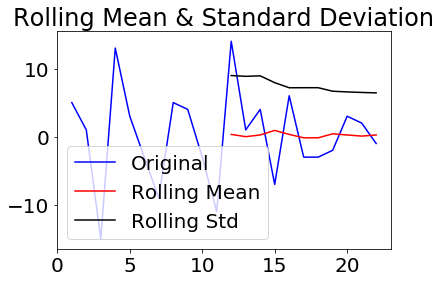

ADF Statistic: -3.5654227909834275
p-value: 0.0064575357640233155
Critical Values:
	1%: -3.9644434814814815
	5%: -3.0849081481481484
	10%: -2.6818144444444445


In [29]:
weighingByMonth_shift=cp.deepcopy(weighingByMonth)
weighingByMonth_shift['count'] = weighingByMonth['count'] - weighingByMonth['count'].shift()
weighingByMonth_shift.dropna(inplace=True)
get_stationarity(weighingByMonth_shift['count'])

## Série Mensal é agora ESTACIONÁRIA